### Background

Walmart, a leading retail giant, operates numerous stores across various locations, each facing unique operational challenges in managing inventory, staffing, and supply chains. Accurately forecasting weekly sales is critical to optimizing these operations and ensuring efficient resource allocation.

### Problem Statement

The current challenge faced by Walmart is to develop a robust regression model that can accurately predict weekly sales for its stores. This model needs to leverage historical sales data, alongside contextual factors such as promotional events, economic conditions, weather patterns, and store-specific attributes.

### Objective

The objective of this project is to build and deploy a predictive model that enhances Walmart's ability to forecast weekly sales. By doing so, Walmart aims to improve inventory management, optimize staffing levels, and streamline supply chain operations across its stores.

### Evaluation Metric

The chosen evaluation metric for assessing the model's performance is **Root Mean Squared Error (RMSE)**. RMSE is preferred because it measures the average magnitude of the errors in the model's predictions, providing a clear indication of how well the model performs in predicting weekly sales figures.

\[
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
\]

### Target Metric

The target metric set for this project is an RMSE of 70000 or lower. Achieving this target ensures that the model can predict weekly sales with a high degree of accuracy, minimizing prediction errors and providing reliable forecasts that support Walmart's operational decisions.

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer, mean_squared_error as MSE
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

sns.set()
np.random.seed(11)

In [96]:
ds = pd.read_csv('/kaggle/input/walmart-sales/Walmart_Sales.csv')

In [97]:
ds.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


### Dataset Description

The dataset used for this project includes the following columns:

- **Store:** Store number where sales data is recorded.
- **Date:** Start date of the sales week.
- **Weekly_Sales:** Total sales amount for the week.
- **Holiday_Flag:** Indicator for the presence (1) or absence (0) of a holiday during the week.
- **Temperature:** Air temperature in the region where the store is located.
- **Fuel_Price:** Cost of fuel in the region during the week.
- **CPI:** Consumer Price Index (CPI) reflecting changes in prices paid by consumers for goods and services over time.
- **Unemployment:** Unemployment rate for the region during the week.

These features provide comprehensive insights into various factors influencing weekly sales at Walmart stores, including economic conditions, weather patterns, and holiday effects.

In [98]:
print(ds.shape, ds.size)

(6435, 8) 51480


In [99]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [100]:
ds.describe(include='all')

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6435,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
unique,NaN,143,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,05-02-2010,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,45,NaN,NaN,NaN,NaN,NaN,NaN
mean,23.000000,NaN,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,NaN,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,NaN,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,NaN,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,NaN,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,NaN,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000


In [101]:
ds.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

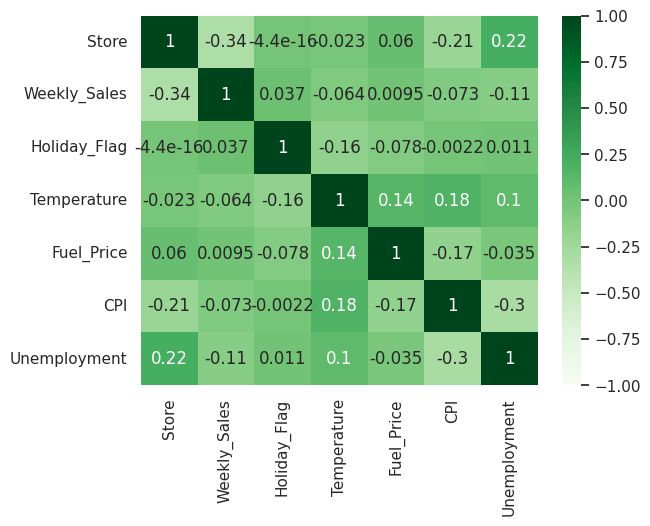

In [102]:
sns.heatmap(ds.select_dtypes(include='number').corr(), vmin=-1, vmax=1, cmap='Greens', annot=True)
plt.show()

In [103]:
ds['Date'] = pd.to_datetime(ds['Date'], format='%d-%m-%Y')

In [104]:
ds['Temperature'] = (ds['Temperature'] - 32) * 5/9

In [105]:
copy = ds.copy()

In [106]:
ds['Date_end'] = ds['Date'] + pd.DateOffset(days=7)

In [107]:
ds['Week_Start'] = ds['Date'].dt.day
ds['Week_End'] = ds['Date_end'].dt.day
ds['Month_Start'] = ds['Date'].dt.month
ds['Month_End'] = ds['Date_end'].dt.month

In [108]:
ds['Quarter'] = ds['Date'].dt.quarter

In [109]:
ds['Year'] = ds['Date'].dt.year

In [110]:
ds['Day_of_year'] = ds['Date'].dt.dayofyear

In [111]:
ds.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Date_end,Week_Start,Week_End,Month_Start,Month_End,Quarter,Year,Day_of_year
0,1,2010-02-05,1643690.90,0,5.727778,2.572,211.096358,8.106,2010-02-12,5,12,2,2,1,2010,36
1,1,2010-02-12,1641957.44,1,3.616667,2.548,211.242170,8.106,2010-02-19,12,19,2,2,1,2010,43
2,1,2010-02-19,1611968.17,0,4.405556,2.514,211.289143,8.106,2010-02-26,19,26,2,2,1,2010,50
3,1,2010-02-26,1409727.59,0,8.127778,2.561,211.319643,8.106,2010-03-05,26,5,2,3,1,2010,57
4,1,2010-03-05,1554806.68,0,8.055556,2.625,211.350143,8.106,2010-03-12,5,12,3,3,1,2010,64


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


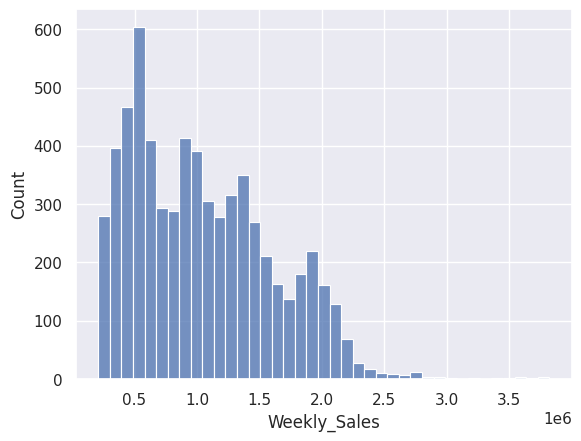

In [113]:
sns.histplot(data=ds, x='Weekly_Sales')
plt.savefig('Weekly Sales Distribution.png')
plt.show()

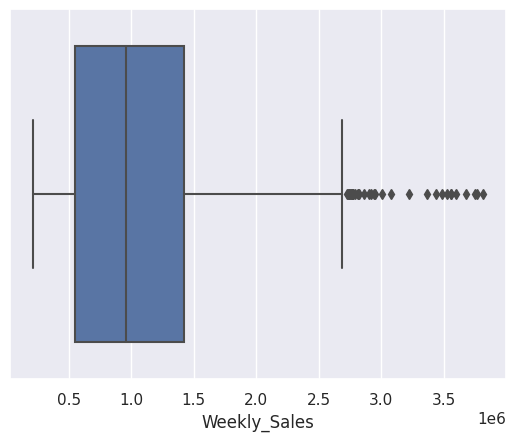

In [19]:
sns.boxplot(data=ds, x='Weekly_Sales')
plt.show()

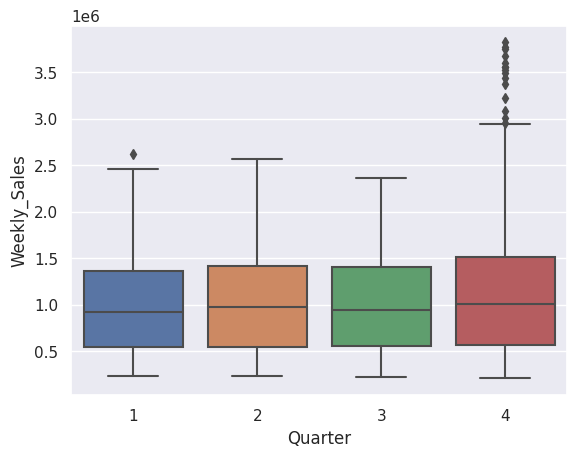

In [114]:
sns.boxplot(data=ds, y='Weekly_Sales', x='Quarter')
plt.savefig('Weekly sales per quarter.png')
plt.show()

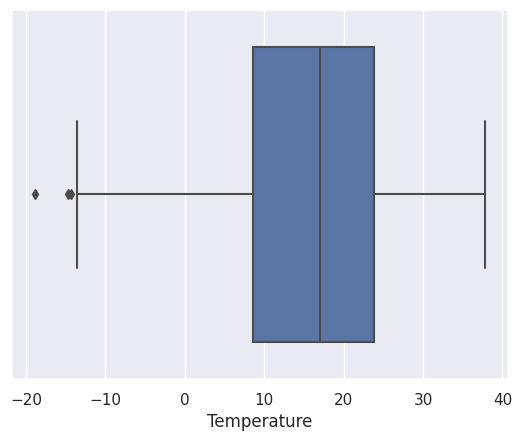

In [21]:
sns.boxplot(data=ds, x='Temperature')
plt.show()

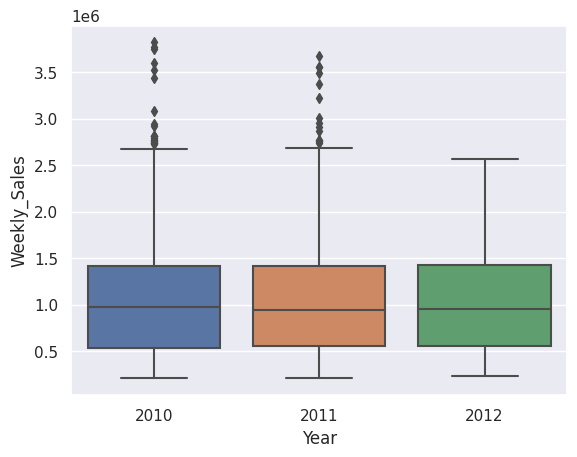

In [115]:
sns.boxplot(data=ds, y='Weekly_Sales', x='Year')
plt.savefig('Weekly sales per year.png')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

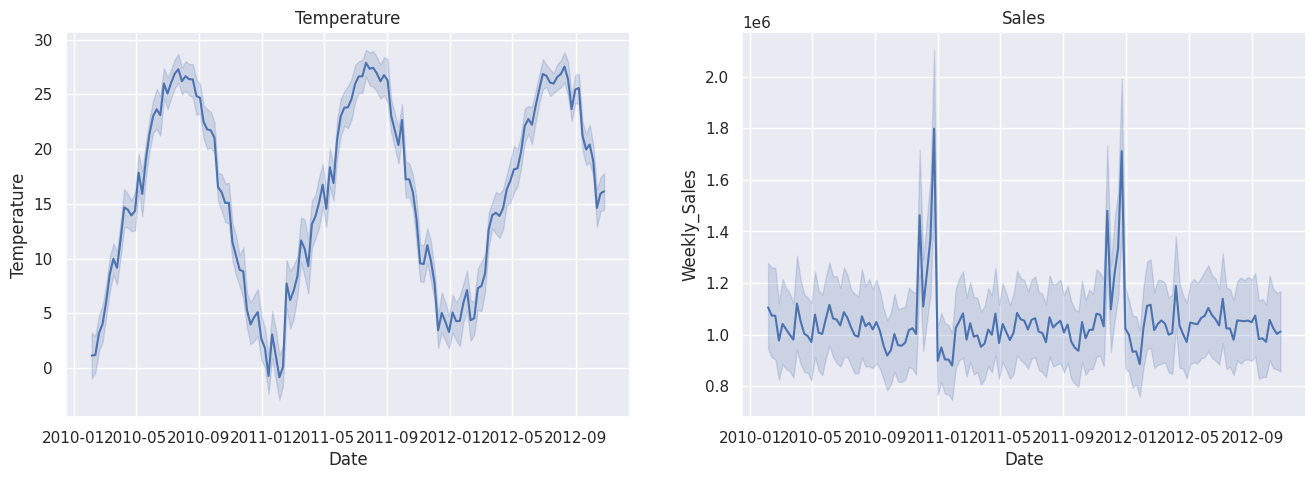

In [132]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,5))
sns.lineplot(data=ds, x='Date', y='Temperature', ax=ax1)
ax1.set_title('Temperature')
sns.lineplot(data=ds, x='Date', y='Weekly_Sales', ax=ax2)
ax2.set_title('Sales')
plt.savefig('Temperature and sales per date.png')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


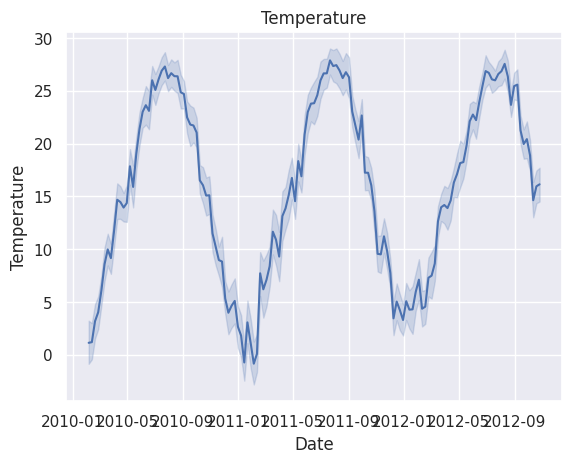

In [24]:
sns.lineplot(data=ds, x='Date', y='Temperature')
plt.title('Temperature')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


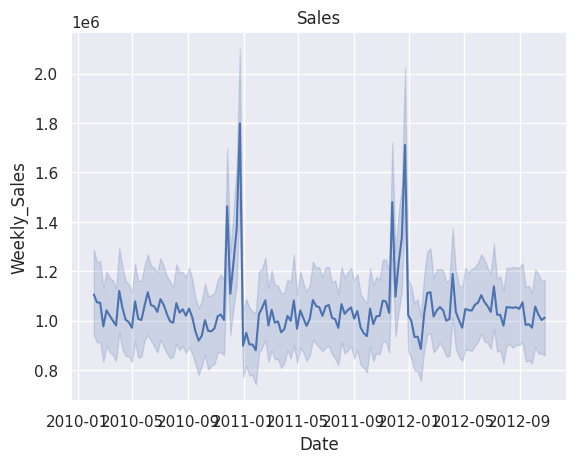

In [25]:
sns.lineplot(data=ds, x='Date', y='Weekly_Sales')
plt.title('Sales')
plt.show()

## Temperature's Effect on Sales

### Key Observation

- **Peak in Weekly Sales:** The analysis reveals that weekly sales consistently hit their peak just before the temperature drops below 5°C.
- **Consumer Behavior:** This trend suggests that consumers may be preparing for colder weather by purchasing more goods in advance of the temperature drop.
- **Seasonal Insights:** To draw further insights, it is valuable to check the specific dates or months when these peaks occur. Identifying these patterns can help in planning inventory, promotions, and staffing.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

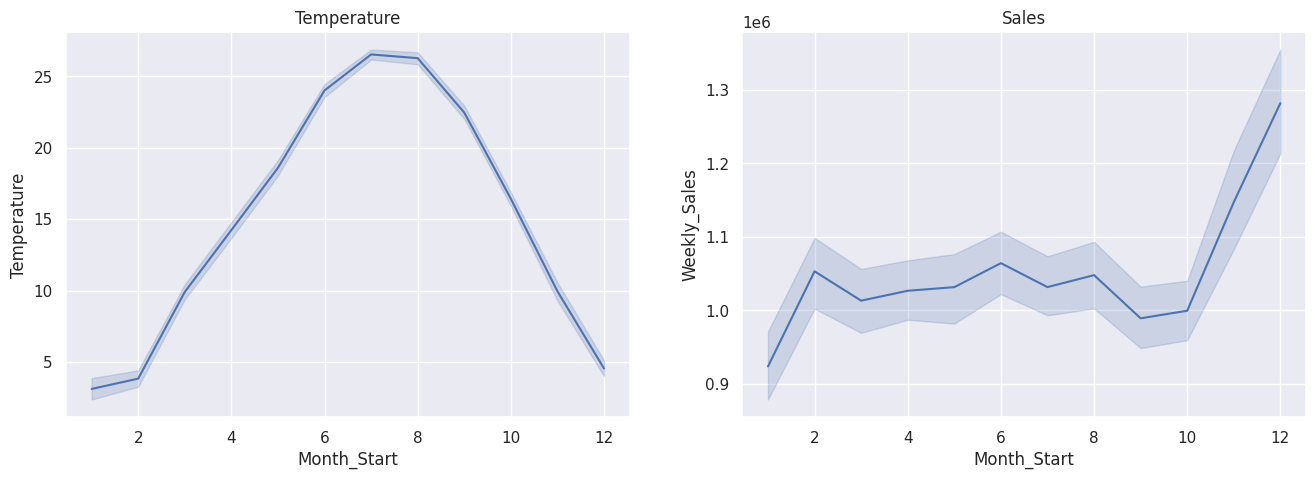

In [118]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,5))
sns.lineplot(data=ds, x='Month_Start', y='Temperature', ax=ax1)
ax1.set_title('Temperature')
sns.lineplot(data=ds, x='Month_Start', y='Weekly_Sales', ax=ax2)
ax2.set_title('Sales')
plt.savefig('Sales and temperature per month.png')
plt.show()

In [ ]:
ds.groupby('Month_Start')[['Temperature', 'Weekly_Sales']].mean()

### Seasonal Effect on Sales

### Key Observations

- **Temperature Trends:** The lowest temperatures are recorded during the latter part of the year, reaching their lowest in January.
- **Festive Period Influence:** The latter part of the year coincides with the most festive period of the year, including holidays such as Thanksgiving, Christmas, and New Year's.
- **Sales Spike Analysis:** The spike in sales observed during the latter part of the year is more likely influenced by the festive period rather than solely by the drop in temperature.


### Implications and Recommendations

- **Inventory Management:** Increase inventory levels prior to the festive period, particularly in November and December, to ensure adequate stock availability and meet heightened demand.
- **Promotional Strategies:** Align promotional activities with the festive season. For example, advertise holiday-specific items and run special offers to attract customers.
- **Staffing Adjustments:** Ensure sufficient staffing levels during the festive season to handle increased customer traffic and maintain high service quality.
- **Further Analysis:** Investigate the specific impact of holidays and festive periods on sales peaks. This can provide a more detailed understanding of seasonal trends and help refine business strategies.

By understanding and leveraging the relationship between seasonal effects, festive periods, and sales, Walmart can optimize its operations to better serve customers and enhance overall business performance.

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,5))
sns.lineplot(data=ds, x='Date', y='Fuel_Price', ax=ax1)
ax1.set_title('Fuel Price')
sns.lineplot(data=ds, x='Date', y='Weekly_Sales', ax=ax2)
ax2.set_title('Sales')
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,5))
sns.lineplot(data=ds, x='Date', y='Unemployment', ax=ax1)
ax1.set_title('Unemployment')
sns.lineplot(data=ds, x='Date', y='Weekly_Sales', ax=ax2)
ax2.set_title('Sales')
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,5))
sns.lineplot(data=ds, x='Date', y='CPI', ax=ax1)
ax1.set_title('CPI')
sns.lineplot(data=ds, x='Date', y='Weekly_Sales', ax=ax2)
ax2.set_title('Sales')
plt.show()

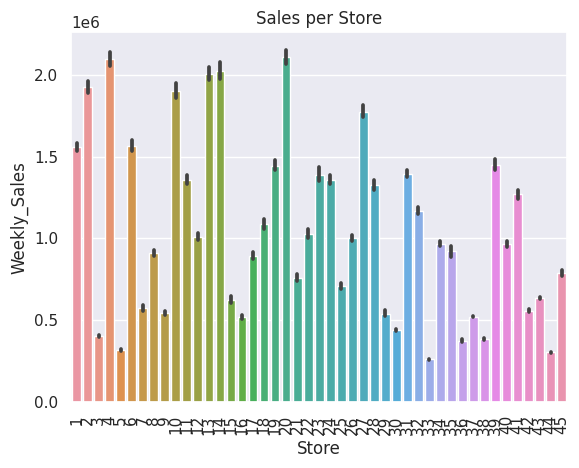

In [26]:
sns.barplot(data=ds, x='Store', y='Weekly_Sales')
plt.title('Sales per Store')
plt.xticks(rotation=90)
plt.show()

In [27]:
best_stores = ds.groupby('Store')['Weekly_Sales'].mean().sort_values(ascending=False)

In [28]:
best_stores = best_stores.reset_index()

In [29]:
best_stores[:10]

,Store,Weekly_Sales
0,20,2.107677e+06
1,4,2.094713e+06
2,14,2.020978e+06
3,13,2.003620e+06
4,2,1.925751e+06
5,10,1.899425e+06
6,27,1.775216e+06
7,6,1.564728e+06
8,1,1.555264e+06
9,39,1.450668e+06


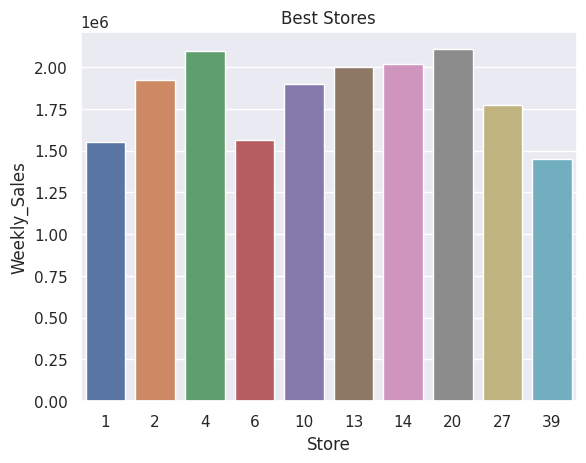

In [130]:
sns.barplot(data=best_stores[:10], x='Store', y='Weekly_Sales')
plt.title('Best Stores')
plt.savefig('best stores.png')
plt.show()

### Best Stores

Based on the analysis of mean weekly sales, the top-performing stores are identified as follows:

- **Store 20:** This store has the highest mean weekly sales, with an average of 2,058,998.00.
- **Store 4:** This store follows closely behind, with a mean weekly sales value of 2,038,739.00.

These stores have demonstrated exceptional performance in terms of sales, and further analysis could help understand the factors contributing to their success. 

#### Recommendations

1. **Best Practices Analysis:** Conduct a detailed analysis of Store 20 and Store 4 to identify the best practices they follow. This can include inventory management, customer service, marketing strategies, and local demographics.

2. **Replication Strategy:** Once the best practices are identified, develop a strategy to replicate these practices in other stores to improve overall performance.

3. **Performance Monitoring:** Continuously monitor the performance of these stores to ensure they maintain their high sales levels and adapt to any changes in market conditions.

4. **Incentive Programs:** Consider implementing incentive programs for other stores based on the performance metrics of Store 20 and Store 4, encouraging them to strive for similar sales achievements.

By leveraging the success of Store 20 and Store 4, Walmart can enhance its overall sales strategy and drive growth across all its stores.

In [31]:
best_stores[-10:]

,Store,Weekly_Sales
35,29,539451.428741
36,16,519247.730070
37,37,518900.281958
38,30,438579.616224
39,3,402704.441049
40,38,385731.653287
41,36,373511.992797
42,5,318011.810490
43,44,302748.866014
44,33,259861.692028


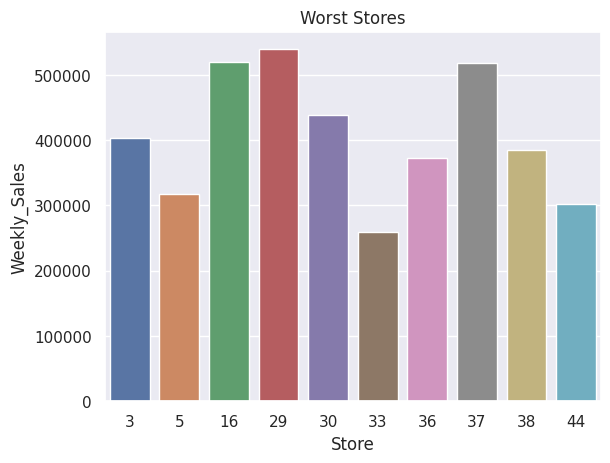

In [129]:
sns.barplot(data=best_stores[-10:], x='Store', y='Weekly_Sales')
plt.title('Worst Stores')
plt.savefig('worst stores.png')
plt.show()

### Worst Stores

Based on the analysis of mean weekly sales, the lowest-performing stores are identified as follows:

- **Store 33:** This store has the lowest mean weekly sales, with an average of 259,861.69.
- **Store 44:** This store follows closely behind, with a mean weekly sales value of 302,748.87.

These stores have demonstrated significantly lower sales performance compared to others, and understanding the factors contributing to their underperformance can help develop strategies for improvement.

#### Recommendations

1. **Root Cause Analysis:** Conduct a thorough investigation to understand the reasons behind the low sales in Store 33 and Store 44. Factors to consider may include location, local competition, store management, inventory issues, and customer feedback.

2. **Tailored Improvement Plans:** Develop specific improvement plans for these stores based on the findings of the root cause analysis. This could involve staff training, changes in inventory management, marketing campaigns, or community engagement initiatives.

3. **Resource Allocation:** Allocate additional resources to these stores to support their improvement efforts. This might include financial investments, additional staffing, or enhanced marketing support.

4. **Performance Monitoring:** Implement a robust performance monitoring system to track the progress of the improvement plans and make necessary adjustments. Regular reviews and feedback loops will be crucial to ensure sustained progress.

5. **Learn from Success:** Leverage the best practices identified from the top-performing stores (Store 20 and Store 4) and apply relevant strategies to Store 33 and Store 44.

By addressing the specific challenges faced by Store 33 and Store 44, Walmart can work towards boosting their sales performance and ensuring a more consistent performance across all its stores.

In [33]:
ds.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Date_end,Week_Start,Week_End,Month_Start,Month_End,Quarter,Year,Day_of_year
0,1,2010-02-05,1643690.90,0,5.727778,2.572,211.096358,8.106,2010-02-12,5,12,2,2,1,2010,36
1,1,2010-02-12,1641957.44,1,3.616667,2.548,211.242170,8.106,2010-02-19,12,19,2,2,1,2010,43
2,1,2010-02-19,1611968.17,0,4.405556,2.514,211.289143,8.106,2010-02-26,19,26,2,2,1,2010,50
3,1,2010-02-26,1409727.59,0,8.127778,2.561,211.319643,8.106,2010-03-05,26,5,2,3,1,2010,57
4,1,2010-03-05,1554806.68,0,8.055556,2.625,211.350143,8.106,2010-03-12,5,12,3,3,1,2010,64


In [34]:
ds.drop(['Date', 'Date_end', 'Month_End', 'Quarter', 'Day_of_year'], axis=1, inplace=True)

In [35]:
ds.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Week_Start,Week_End,Month_Start,Year
0,1,1643690.90,0,5.727778,2.572,211.096358,8.106,5,12,2,2010
1,1,1641957.44,1,3.616667,2.548,211.242170,8.106,12,19,2,2010
2,1,1611968.17,0,4.405556,2.514,211.289143,8.106,19,26,2,2010
3,1,1409727.59,0,8.127778,2.561,211.319643,8.106,26,5,2,2010
4,1,1554806.68,0,8.055556,2.625,211.350143,8.106,5,12,3,2010


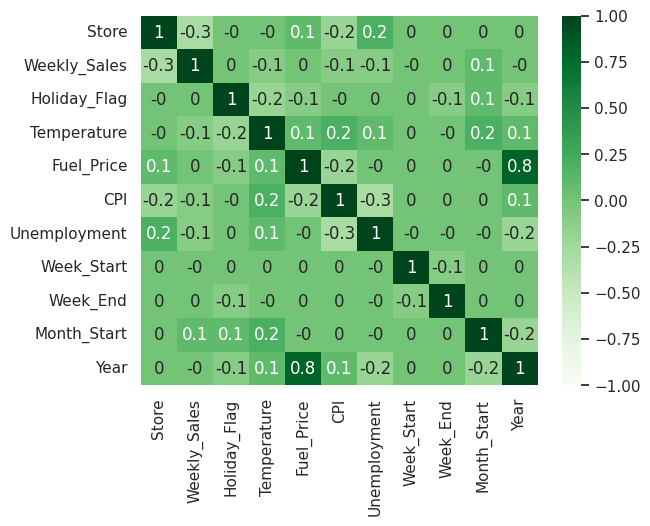

In [36]:
sns.heatmap(ds.corr().round(1), vmin=-1, vmax=1, cmap='Greens', annot=True)
plt.show()

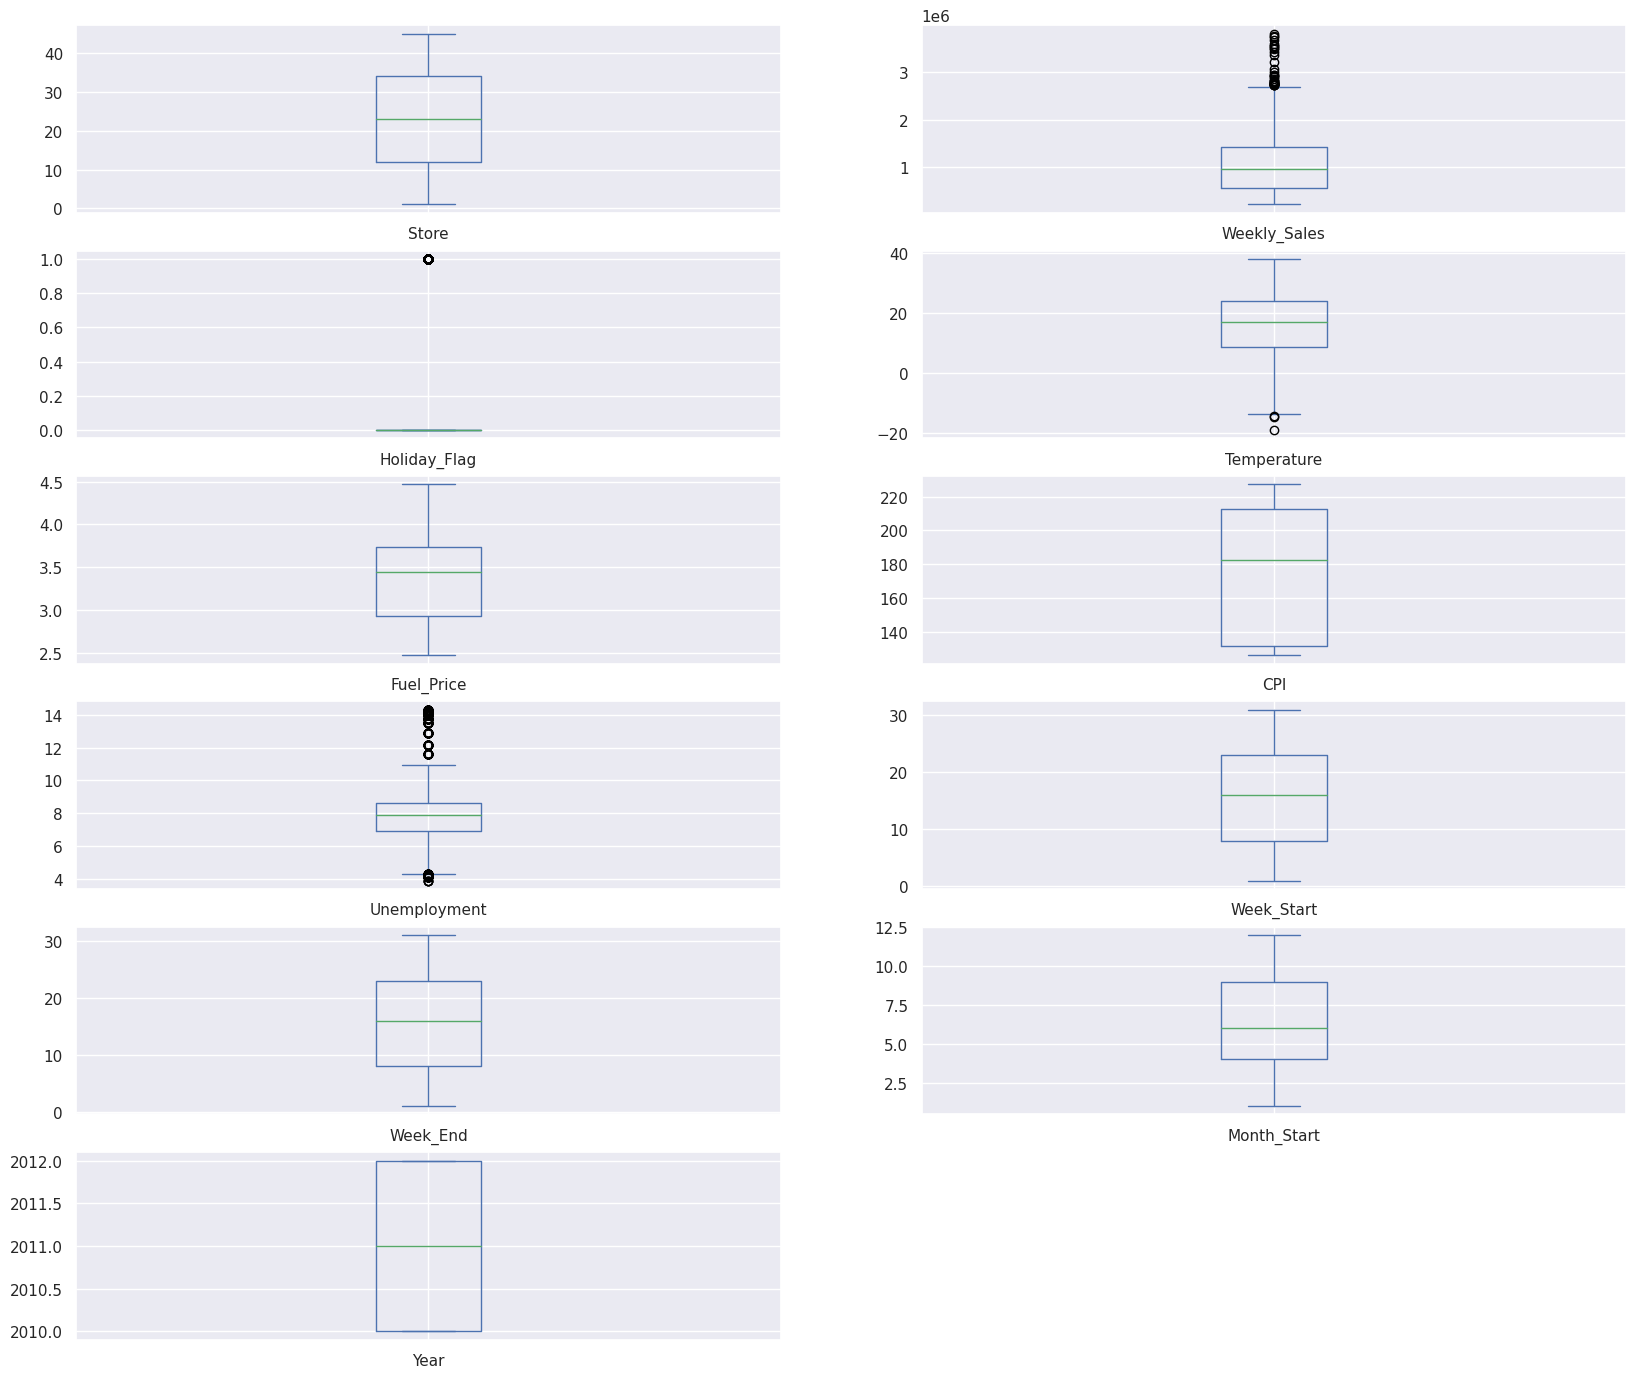

In [37]:
ds.select_dtypes(include='number').plot(kind='box', subplots=True, layout=(7,2), figsize=(20, 20))
plt.show()

In [38]:
def remove_outliers(col, ds):
    '''
    Remove outliers from a column, using the inter-quartile range
    - calculate the upper limit and lower limit based on the IQR
    - filter out observations that fall out of range (< lower_limit or > upper_limit)
    '''
   
    q1 = ds[col].quantile(0.25)
    q3 = ds[col].quantile(0.75)
    
    iqr = q3 - q1
    
    upper_limit = q3 + 1.5 * iqr
    lower_limit = q1 - 1.5 * iqr
    
    return ds[~((ds[col] < lower_limit) | (ds[col] > upper_limit))]

In [39]:
ds = remove_outliers('Weekly_Sales', ds)
ds = remove_outliers('Unemployment', ds)

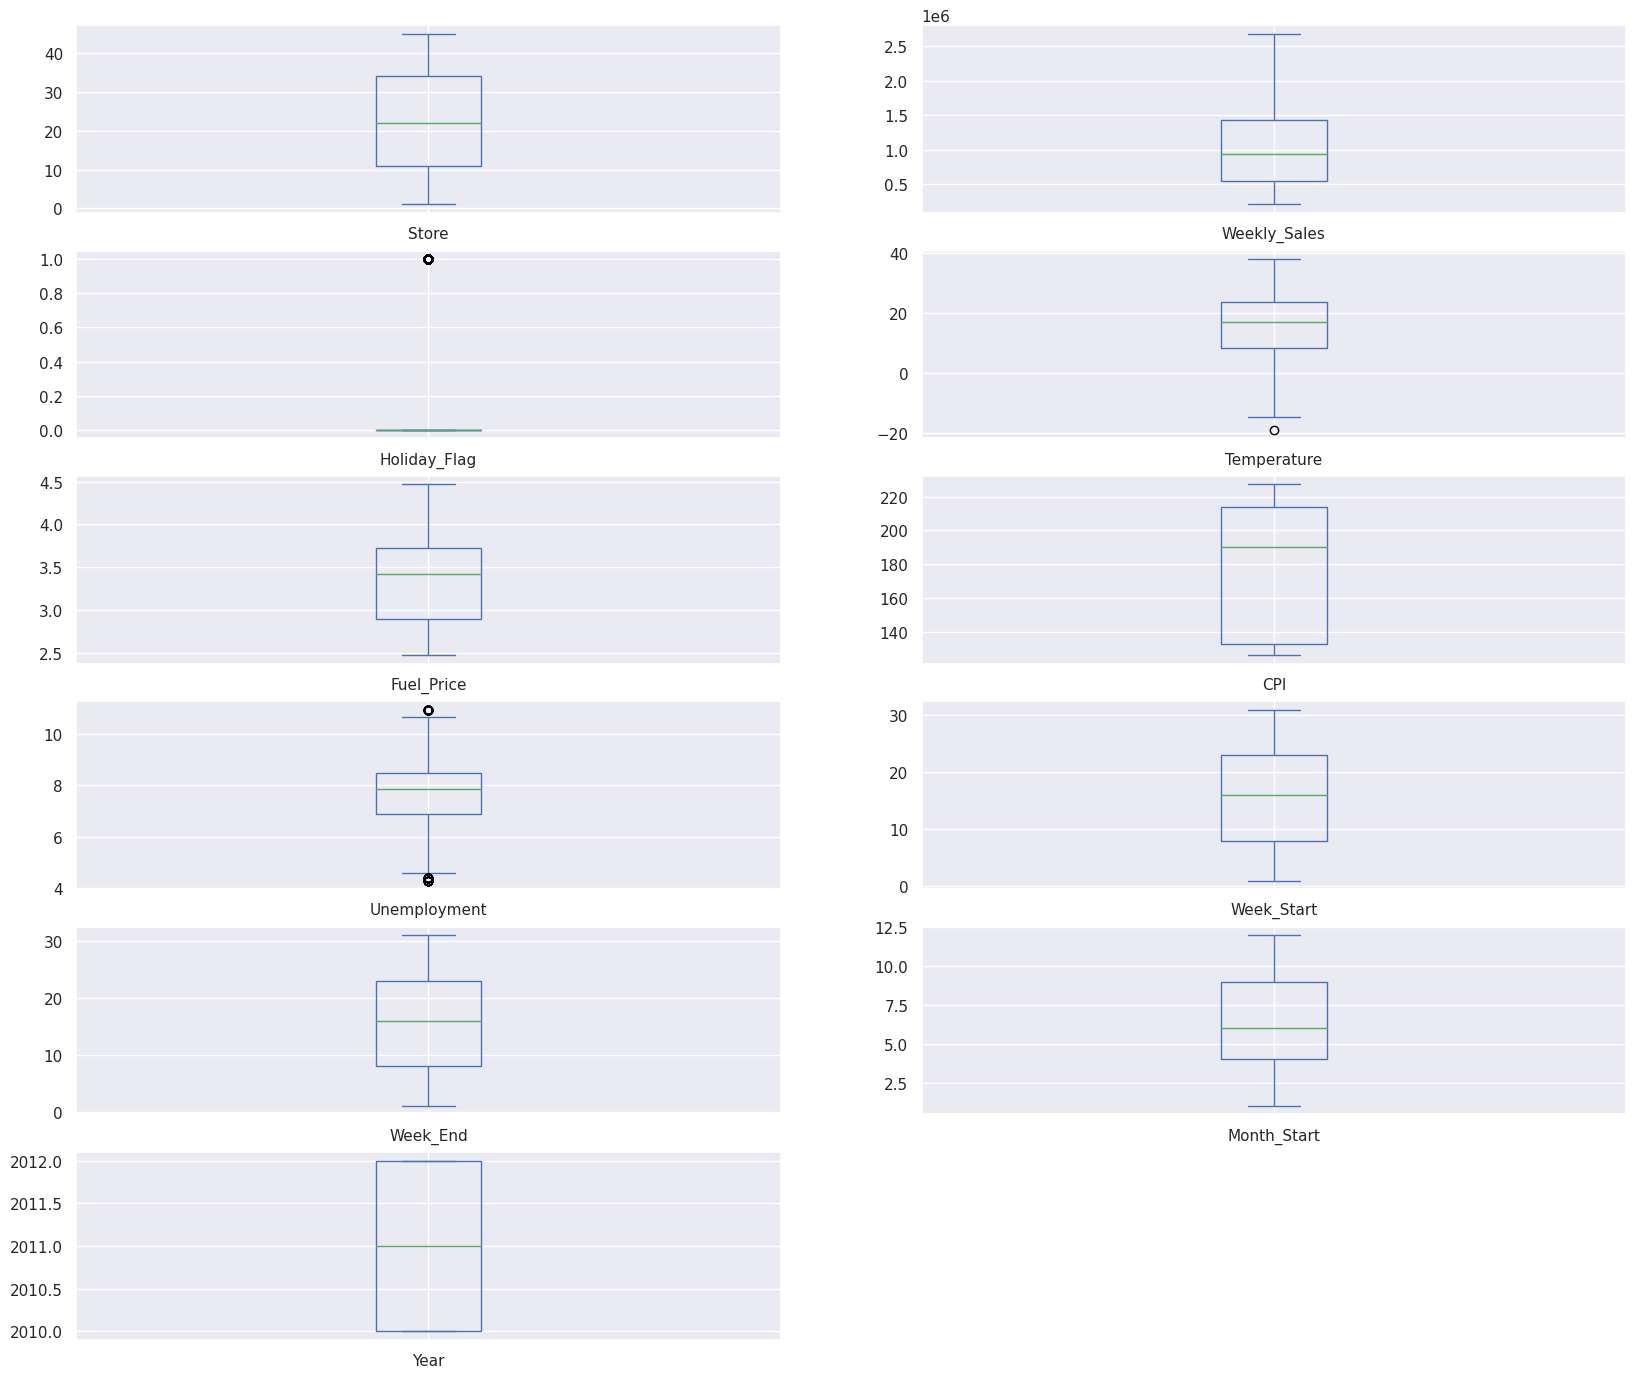

In [40]:
ds.select_dtypes(include='number').plot(kind='box', subplots=True, layout=(7,2), figsize=(20, 20))
plt.show()

In [41]:
X = ds.drop('Weekly_Sales', axis=1).values
y = ds['Weekly_Sales'].values

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

In [43]:
rfc = RandomForestRegressor(random_state=11)

In [44]:
rfc.fit(X_train, y_train)

RandomForestRegressor(random_state=11)

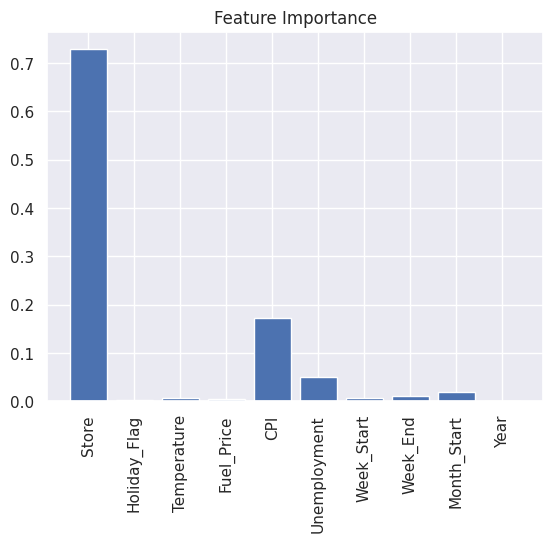

In [45]:
plt.bar(ds.drop('Weekly_Sales', axis=1).columns, rfc.feature_importances_)
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.savefig('feature_importance.png')
plt.show()

### Feature Importance Analysis

Based on the exploratory analysis conducted, the importance of features influencing weekly sales can be ranked as follows:

1. **Store:** Identified as the most important feature influencing weekly sales. Certain stores consistently outperform others, indicating significant variability in performance based on store location, size, customer base, and management practices.

2. **CPI (Consumer Price Index):** Found to be the second most influential feature. Changes in CPI can impact consumer purchasing power and spending behavior, thereby affecting weekly sales in retail settings like Walmart.

3. **Unemployment Rate:** This feature ranks third in importance. Higher unemployment rates may correlate with reduced consumer confidence and discretionary spending, potentially impacting weekly sales negatively.

4. **Month:** Identified as the fourth most influential feature. Seasonal variations, holidays, and special events throughout the year can significantly influence consumer spending patterns and overall sales performance.

### Recommendations

1. **Store-Specific Strategies:** Develop tailored strategies for each store based on their individual performance metrics and local market conditions. This could involve optimizing inventory levels, adjusting pricing strategies, and enhancing customer service.

2. **Economic Monitoring:** Continuously monitor CPI trends and unemployment rates to anticipate changes in consumer behavior and adjust business operations accordingly.

3. **Seasonal Planning:** Align promotional campaigns, inventory stocking, and staffing levels with seasonal variations identified through the analysis of monthly sales patterns.

4. **Data-Driven Decisions:** Use insights from feature importance analysis to prioritize resource allocation and strategic initiatives that can maximize sales performance across different stores and economic conditions.

By leveraging the insights gained from analyzing these key features, Walmart can enhance its operational efficiency, improve sales forecasting accuracy, and ultimately drive sustainable growth in its retail business.

In [46]:
pred = rfc.predict(X_test)

In [47]:
print(f"RMSE: {np.sqrt(MSE(y_test, pred))}")

RMSE: 100639.60998646486


In [48]:
pd.DataFrame({
    'Feature': ds.drop('Weekly_Sales', axis=1).columns, 
    'Importance': rfc.feature_importances_.round(2)
}).sort_values('Importance', ascending=False)

,Feature,Importance
0,Store,0.73
4,CPI,0.17
5,Unemployment,0.05
8,Month_Start,0.02
2,Temperature,0.01
6,Week_Start,0.01
7,Week_End,0.01
1,Holiday_Flag,0.00
3,Fuel_Price,0.00
9,Year,0.00


In [49]:
new_ds = ds.drop(['Holiday_Flag', 'Fuel_Price', 'Year'], axis=1)

In [50]:
new_ds.head()

,Store,Weekly_Sales,Temperature,CPI,Unemployment,Week_Start,Week_End,Month_Start
0,1,1643690.90,5.727778,211.096358,8.106,5,12,2
1,1,1641957.44,3.616667,211.242170,8.106,12,19,2
2,1,1611968.17,4.405556,211.289143,8.106,19,26,2
3,1,1409727.59,8.127778,211.319643,8.106,26,5,2
4,1,1554806.68,8.055556,211.350143,8.106,5,12,3


In [51]:
cat = CatBoostRegressor(random_state=11, verbose=0)
lgbm = LGBMRegressor(random_state=11, verbose=-1)
xgb = XGBRegressor(random_state=11)

In [52]:
X = new_ds.drop('Weekly_Sales', axis=1).values
y = new_ds['Weekly_Sales'].values

In [53]:
scaler = StandardScaler()

In [54]:
X_scaled = scaler.fit_transform(X)

In [55]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [56]:
scoring_metrics = make_scorer(MSE, 
                              greater_is_better=False
                             )

In [57]:
xgb_scores = cross_val_score(xgb, X_scaled, y, cv=cv, scoring=scoring_metrics, n_jobs=-1)
lgbm_scores = cross_val_score(lgbm, X_scaled, y, cv=cv, scoring=scoring_metrics, n_jobs=-1)
cat_scores = cross_val_score(cat, X_scaled, y, cv=cv, scoring=scoring_metrics, n_jobs=-1)

In [58]:
print(f"xgb scores: {np.sqrt(np.abs(xgb_scores))}, mean: {np.sqrt(np.abs(xgb_scores.mean()))}")
print(f"lgbm scores: {np.sqrt(np.abs(lgbm_scores))}, mean: {np.sqrt(np.abs(lgbm_scores.mean()))}")
print(f"cat scores: {np.sqrt(np.abs(cat_scores))}, mean: {np.sqrt(np.abs(cat_scores.mean()))}")

xgb scores: [82806.8842881  70961.95322658 67694.84716744 73861.8408292
 83335.4902387 ], mean: 75994.14015338245
lgbm scores: [85930.02944008 80005.4641243  78125.30703103 78293.32087468
 80182.55985198], mean: 80557.42653041052
cat scores: [83337.09017286 75975.73605281 70185.58813007 73224.10260885
 76353.67014499], mean: 75940.83485963233


In [59]:
param_grid_xgb = {
    'max_depth': np.arange(5, 10),
    'n_estimators': [1000, 1500],
    'min_child_weight': np.arange(1,3),
#     'colsample_bynode': [0.6, 0.8, 1.0] 
}

xgb_grid = GridSearchCV(xgb, param_grid_xgb, scoring=scoring_metrics, cv=cv, n_jobs=-1)

In [60]:
param_grid_lgbm = {
    'max_depth': np.arange(5, 10),
    'n_estimators': [1000, 1500],
    'min_child_samples': np.arange(1, 3),
    'num_leaves': [31, 50, 100],
#     'feature_fraction_bynode': [0.6, 0.8, 1.0]
}

lgbm_grid = GridSearchCV(lgbm, param_grid_lgbm, scoring=scoring_metrics, cv=cv, n_jobs=-1)

In [61]:
param_grid_cat = {
    'depth': np.arange(5, 10),
    'iterations': [1000, 1500],
    'min_data_in_leaf': np.arange(1, 3),
#     'random_strength': [1, 10]
}

cat_grid = GridSearchCV(cat, param_grid_cat, scoring=scoring_metrics, cv=cv, n_jobs=-1)

In [62]:
xgb_grid.fit(X_scaled, y)
lgbm_grid.fit(X_scaled, y)
cat_grid.fit(X_scaled, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=<catboost.core.CatBoostRegressor object at 0x7959d5cb59f0>,
             n_jobs=-1,
             param_grid={'depth': array([5, 6, 7, 8, 9]),
                         'iterations': [1000, 1500],
                         'min_data_in_leaf': array([1, 2])},
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

In [63]:
print(f"Best score: {np.sqrt(np.abs(xgb_grid.best_score_))}, Best params: {xgb_grid.best_params_}")
print(f"Best score: {np.sqrt(np.abs(lgbm_grid.best_score_))}, Best params: {lgbm_grid.best_params_}")
print(f"Best score: {np.sqrt(np.abs(cat_grid.best_score_))}, Best params: {cat_grid.best_params_}")

Best score: 74320.62426627308, Best params: {'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 1000}
Best score: 66973.67385566857, Best params: {'max_depth': 9, 'min_child_samples': 2, 'n_estimators': 1500, 'num_leaves': 31}
Best score: 69362.47036873044, Best params: {'depth': 9, 'iterations': 1500, 'min_data_in_leaf': 1}


- Best score: 74320.62426627308, Best params: {'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 1000}
- Best score: 66973.67385566857, Best params: {'max_depth': 9, 'min_child_samples': 2, 'n_estimators': 1500}
- Best score: 69362.47036873044, Best params: {'depth': 9, 'iterations': 1500, 'min_data_in_leaf': 1}

In [79]:
param_grid_lgbm = {
    'max_depth': np.arange(8, 10),
    'n_estimators': [1500],
    'min_child_samples': [2, 20],
    'num_leaves': [31, 50],
    'reg_alpha': [0.0, 0.5],
    'reg_lambda': [0.0, 0.1]
#     'feature_fraction_bynode': [0.6, 0.8, 1.0]
}

lgbm_grid = GridSearchCV(lgbm, param_grid_lgbm, scoring=scoring_metrics, cv=cv, n_jobs=-1)
lgbm_grid.fit(X_scaled, y)
print(f"Best score: {np.sqrt(np.abs(lgbm_grid.best_score_))}, Best params: {lgbm_grid.best_params_}")

Best score: 66825.28594173203, Best params: {'max_depth': 9, 'min_child_samples': 2, 'n_estimators': 1500, 'num_leaves': 31, 'reg_alpha': 0.5, 'reg_lambda': 0.0}


Best score: 66825.28594173203, Best params: {'max_depth': 9, 'min_child_samples': 2, 'n_estimators': 1500, 'num_leaves': 31, 'reg_alpha': 0.5, 'reg_lambda': 0.0}

In [80]:
knn = KNeighborsRegressor()

param_grid_knn = {
    'n_neighbors': [5,10,15,20],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20],
    'p': [1, 2]
}

knn_grid = GridSearchCV(knn, param_grid_knn, cv=cv, scoring=scoring_metrics, n_jobs=-1)
knn_grid.fit(X_scaled, y)
print(f"Best score: {np.sqrt(np.abs(knn_grid.best_score_))}, Best params: {knn_grid.best_params_}")

Best score: 400882.24848459545, Best params: {'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}


In [92]:
estimators = [
    ('cat', CatBoostRegressor(random_state=11, verbose=0, **cat_grid.best_params_)),
#     ('xgb', XGBRegressor(random_state=11, **xgb_grid.best_params_)),
    ('lgbm', LGBMRegressor(random_state=11, verbose=-1, **lgbm_grid.best_params_)),
    ('ada', AdaBoostRegressor(LGBMRegressor(random_state=11, verbose=-1, **lgbm_grid.best_params_), n_estimators=100))
]

In [93]:
vtr = VotingRegressor(estimators=estimators, n_jobs=-1)

In [94]:
vtr_scores = cross_val_score(vtr, X_scaled, y, cv=cv, scoring=scoring_metrics, n_jobs=-1)
print(f"vtr scores: {np.sqrt(np.abs(vtr_scores))}, mean: {np.sqrt(np.abs(vtr_scores.mean()))}")

vtr scores: [71591.29889673 65925.07858009 57842.42624258 65526.64993954
 65880.6947114 ], mean: 65499.89942754815


- vtr scores: [72505.22060759 65892.68552378 58692.10073605 65240.65255177
 65425.04234091], mean: 65696.87149384352

In [90]:
ada = AdaBoostRegressor(LGBMRegressor(random_state=11, verbose=-1, **lgbm_grid.best_params_), n_estimators=100)

In [91]:
ada_scores = cross_val_score(ada, X_scaled, y, cv=cv, scoring=scoring_metrics, n_jobs=-1)
print(f"ada scores: {np.sqrt(np.abs(ada_scores))}, mean: {np.sqrt(np.abs(ada_scores.mean()))}")

ada scores: [71025.05716896 67737.10986069 59588.4798921  67330.65551899
 68117.42935293], mean: 66868.62207082217


In [121]:
results = {
    'model': ['xgb', 'lgbm', 'cat', 'vtr', 'ada', 'knn'],
    'score': [
        np.sqrt(np.abs(xgb_grid.best_score_)),
        np.sqrt(np.abs(lgbm_grid.best_score_)),
        np.sqrt(np.abs(cat_grid.best_score_)),
        np.sqrt(np.abs(vtr_scores.mean())),
        np.sqrt(np.abs(ada_scores.mean())),
        np.sqrt(np.abs(knn_grid.best_score_))
    ]
}

In [131]:
results_df = pd.DataFrame(results)

results_df

,model,score
0,xgb,74320.624266
1,lgbm,66825.285942
2,cat,69362.470369
3,vtr,65499.899428
4,ada,66868.622071
5,knn,400882.248485


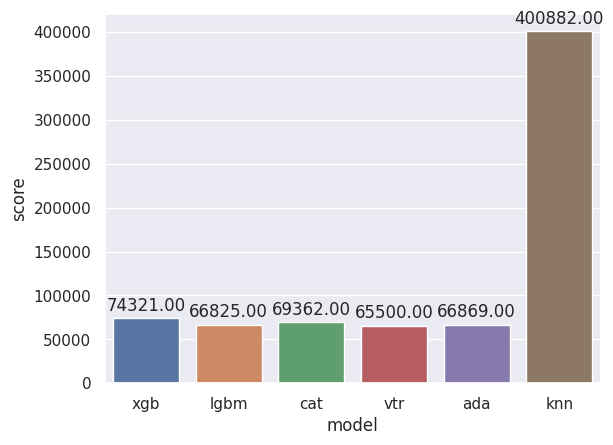

In [128]:
ax = sns.barplot(data=results_df.round(0), x='model', y='score', errorbar=None)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')
plt.title('RMSE of Models')
plt.savefig('model scores.png')
plt.show()

### Evaluating all models

- The Voting Regressor with (LGBM, CAT and ADA) estimators recorded the best scores.
- The RMSE of 65500 is less than the 70000 target metric we selected

### Conclusion
In this project, we developed and evaluated a regression model to accurately estimate weekly sales amounts for Walmart stores. Our objective was to enhance inventory management, optimize staffing, and improve supply chain efficiency with a target RMSE of less than 70,000. After extensive data preprocessing, feature engineering, and model tuning, we successfully achieved this target with the Voting Regressor (VTR) model, which combines LightGBM, CatBoost, and AdaBoost estimators.

### Model Performance
The Voting Regressor (VTR) achieved an RMSE of 65,499.90, outperforming other models:
1. **Voting Regressor (VTR) with LGBM, CAT, and ADA estimators:** 65,499.90
2. **LightGBM (LGBM):** 66,825.29
3. **CatBoost (CAT):** 69,362.47
4. **AdaBoost (ADA):** 66,868.62
5. **XGBoost (XGB):** 74,320.62
6. **K-Nearest Neighbors (KNN):** 400,882.25

### Business Impact
The successful implementation of the VTR model with an RMSE of 65,499.90 demonstrates significant potential for operational improvements at Walmart:

1. **Enhanced Inventory Management:** With more accurate sales forecasts, Walmart can optimize inventory levels, reducing both stockouts and overstock situations. This optimization leads to lower holding costs and higher customer satisfaction due to better product availability.

2. **Optimized Staffing:** Accurate weekly sales predictions allow for better alignment of staffing levels with expected store traffic. This ensures high customer service quality during peak periods while minimizing unnecessary labor costs during slower periods.

3. **Improved Supply Chain Efficiency:** Reliable sales forecasts enable better planning and coordination with suppliers. This results in more efficient replenishment processes, reduced lead times, and lower logistics costs.

### Recommendations
Based on the model evaluation results and the successful achievement of the target RMSE, we recommend the following actions:

1. **Implement the Voting Regressor (VTR):** Deploy the VTR model, which combines LightGBM, CatBoost, and AdaBoost, for weekly sales predictions. This model demonstrated the best performance, achieving an RMSE of 65,499.90, well below the target of 70,000.

2. **Regular Model Monitoring and Retraining:** Continuously monitor the performance of the deployed model and retrain it with new data to maintain accuracy over time. This is essential to adapt to changing sales patterns due to seasonality, market trends, and other factors.

3. **Incorporate Sales Predictions into Business Processes:** Utilize the model's predictions for informed decision-making in inventory management, staffing, and supply chain operations. Ensure relevant stakeholders are trained to understand and leverage the insights provided by the model.

4. **Explore Additional Features:** Investigate further feature engineering possibilities that might improve model accuracy, such as incorporating more granular weather data, local events, and detailed competitor analysis.

By implementing these recommendations, Walmart can effectively leverage advanced predictive analytics to drive substantial improvements in inventory management, staffing, and supply chain efficiency, ultimately enhancing overall operational performance.